In [1]:
import os

import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from matplotlib import pyplot as plt

sns.set()

In [2]:
# project files
from rp_model.files import set_files_directory

set_files_directory("./files")

from rp_model.calc import (
    game, FitOptions, download_data, refresh_pokedex, compute_rp, make_precomputed_columns, make_initial_guess
)
from rp_model.utils import (
    pack, unpack, simplify_opt_result, table, progressive_soft_round_loop, RoundApprox, DataStore
)

RP model file path: C:\Users\jckin\Documents\Untitled Folder\RP fit\files


In [3]:
# stuff for display

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 120)

In [4]:
refresh_rp_file = True

if refresh_rp_file:
    refresh_pokedex()
    data = download_data()
    data.to_pickle(FitOptions.data_file)
else:
    data = pd.read_pickle(FitOptions.data_file)

In [5]:
data.describe()
data.head()

,Level,RP,MS lvl,ModelRP,Difference,Freq1,Berry1,Ing1P,NrgNat,Helps per hour,IngrMult,SkillMult,BerryD,IngD,SklVal,FreqL,HelpNat,IngrNat,Ingr%,SkillNat,Skill%,BerryL,Dupes,Diff -0.1% ingr,Diff +0.1% ingr,Diff,Amnt,Ing2P,MiscMult,RP Multiplier,HelpSub,IngrSub,SkillSub
count,11462.000000,11462.000000,11462.000000,11462.000000,11462.000000,11462.000000,11462.000000,11462.000000,11462.000000,11462.000000,11462.000000,11462.000000,11462.000000,11462.000000,11462.000000,11462.000000,11462.000000,11462.000000,11462.000000,11462.000000,11462.000000,11462.000000,11462.0,11462.000000,11462.000000,11462.000000,11462.000000,11462.000000,7813.000000,11462.000000,7813.000000,7813.000000,7813.000000
mean,14.552783,782.833973,1.658786,782.834584,0.000611,3763.287384,28.221078,108.868871,0.993739,1.097227,0.211052,0.039558,63.227360,154.257808,965.603298,3576.317271,0.987917,0.999860,0.203678,1.008637,0.037348,42.369133,1.0,-0.648480,0.617092,-0.015574,0.236433,11.324289,1.053428,1.042793,0.973552,1.046653,1.058794
std,9.731065,595.617042,1.140757,595.616947,0.024706,998.336079,2.740878,16.184209,0.044252,0.339577,0.058370,0.022455,37.051091,69.284601,865.532410,1064.734938,0.057061,0.117324,0.040687,0.120315,0.019933,12.010565,0.0,0.900577,0.918203,0.557976,0.851369,38.073443,0.103646,0.084297,0.051829,0.113172,0.124552
min,1.000000,245.000000,1.000000,245.000000,0.000000,2200.000000,24.000000,90.000000,0.920000,0.520000,0.100000,0.006400,25.000000,90.000000,400.000000,1410.860000,0.900000,0.800000,0.130000,0.800000,0.010000,24.000000,1.0,-34.580000,-35.050000,-34.810000,0.000000,0.000000,0.920000,1.000000,0.790000,1.000000,1.000000
25%,7.000000,394.000000,1.000000,394.000000,0.000000,2900.000000,26.000000,98.000000,1.000000,0.820000,0.170000,0.020000,38.000000,101.000000,400.000000,2676.800000,1.000000,1.000000,0.170000,1.000000,0.020000,34.000000,1.0,-0.900000,0.142900,-0.250000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,12.000000,581.000000,1.000000,581.000000,0.000000,3700.000000,28.000000,103.000000,1.000000,1.040000,0.202400,0.038000,51.000000,121.000000,880.000000,3437.000000,1.000000,1.000000,0.200000,1.000000,0.040000,40.000000,1.0,-0.500000,0.490000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,20.000000,908.000000,2.000000,908.000000,0.000000,4400.000000,31.000000,121.000000,1.000000,1.340000,0.247800,0.052000,74.000000,202.000000,880.000000,4338.400000,1.000000,1.000000,0.230000,1.000000,0.050000,47.000000,1.0,-0.160000,0.910000,0.240000,0.000000,0.000000,1.120000,1.000000,1.000000,1.000000,1.000000
max,53.000000,5338.000000,7.000000,5338.000000,1.000000,6300.000000,35.000000,151.000000,1.080000,2.550000,0.517400,0.220000,351.000000,511.000000,5843.000000,6916.140000,1.100000,1.200000,0.340000,1.200000,0.140000,117.000000,1.0,0.950000,7.840000,1.410000,8.000000,342.000000,1.550000,1.440000,1.000000,1.540000,1.540000


,Pokemon,Level,RP,NatureEN/ZH,MS lvl,Source,ModelRP,Difference,Nature,ID,NatureP,NatureN,Type,Class,MSkill,Freq1,Berry1,Ing1,Ing1P,NrgNat,Helps per hour,IngrMult,SkillMult,BerryD,IngD,SklVal,FreqL,HelpNat,IngrNat,Ingr%,SkillNat,Skill%,BerryL,Dupes,DupeMatch,Diff -0.1% ingr,Diff +0.1% ingr,Diff,Sub Skill 1,Sub Skill 2,Ingredient 2,Amnt,Ing2P,MiscMult,RP Multiplier,HelpSub,IngrSub,SkillSub,Sub Skill 3
0,Arbok,8.0,531.0,Hardy,1.0,Questions help guides,531.0,0.0,Neutral,ArbokNeutral81,-,-,Poison,Berries,Charge Energy S,3700.0,32.0,Bean Sausage,103.0,1.00,0.98,0.26,0.06,78.0,103.0,400.0,3648.20,1.0,1.0,0.26,1.0,0.06,39,1,True,-0.4900,-0.2200,-0.3600,,,,0.0,0.0,NaN,1.0,NaN,NaN,NaN,
1,Arbok,8.0,538.0,Quiet,1.0,Questions help guides,538.0,0.0,Quiet,ArbokQuiet81,Ingredient Finding,Exp Gains,Poison,Berries,Charge Energy S,3700.0,32.0,Bean Sausage,103.0,1.00,0.98,0.32,0.06,78.0,103.0,400.0,3648.20,1.0,1.2,0.26,1.0,0.06,39,1,True,-0.1400,0.1300,-0.0100,,,,0.0,0.0,NaN,1.0,NaN,NaN,NaN,
2,Arbok,9.0,528.0,Bold,1.0,,528.0,0.0,Bold,ArbokBold91,Energy Recovery,Speed of Help,Poison,Berries,Charge Energy S,3700.0,32.0,Bean Sausage,103.0,1.08,0.89,0.26,0.06,80.0,103.0,400.0,4004.88,1.1,1.0,0.26,1.0,0.06,40,1,True,0.1956,0.4548,0.3252,,,,0.0,0.0,NaN,1.0,NaN,NaN,NaN,
3,Arbok,9.0,539.0,Hardy,1.0,Double Jumper,539.0,0.0,Neutral,ArbokNeutral91,-,-,Poison,Berries,Charge Energy S,3700.0,32.0,Bean Sausage,103.0,1.00,0.98,0.26,0.06,80.0,103.0,400.0,3640.80,1.0,1.0,0.26,1.0,0.06,40,1,True,-0.4700,-0.2000,-0.3400,,,,0.0,0.0,NaN,1.0,NaN,NaN,NaN,
4,Arbok,9.0,574.0,Naughty,1.0,Rate My Mon,574.0,0.0,Naughty,ArbokNaughty91,Speed of Help,Main Skill Chance,Poison,Berries,Charge Energy S,3700.0,32.0,Bean Sausage,103.0,1.00,1.09,0.26,0.05,80.0,103.0,400.0,3276.72,0.9,1.0,0.26,0.8,0.06,40,1,True,0.1200,0.4100,0.2600,,,,0.0,0.0,NaN,1.0,NaN,NaN,NaN,


In [6]:
FitOptions.rounding.final_rp = RoundApprox.Pass
FitOptions.rounding.bonus = RoundApprox.Exact
FitOptions.rounding.period = RoundApprox.Pass
FitOptions.rounding.components = RoundApprox.Pass


In [7]:
# Make an initial guess
# Pack the dictionary into a 1-D vector.
# Also store information on how to unpack that vector

x0, unpack_info = pack(*make_initial_guess())


In [8]:
# Compute per sample information about help time, nature, subskills etc
computed = make_precomputed_columns(data)

# Do we match the sheet? Yes
(computed.helps_per_hour - data["Helps per hour"]).describe()

count    1.146200e+04
mean    -3.664282e-05
std      6.042494e-04
min     -1.000000e-02
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.440892e-16
Name: Helps per hour, dtype: float64

In [9]:
# We compute the RP model in rp_model.py
# Here we create closure to glue the pieces together.

def RP(x):
    return compute_rp(x, data, computed, unpack_info)


def residual(x):
    return data["RP"].to_numpy() - RP(x)

In [11]:
RP(x0)

array([ 537.54591236,  545.09509483,  535.13805068, ..., 3658.26151223,
       2764.25667926, 2726.6067292 ])

count    11462.000000
mean        -1.974525
std         25.369866
min       -302.000000
25%         -9.000000
50%         -1.000000
75%          5.000000
max        235.000000
Name: RP, dtype: float64

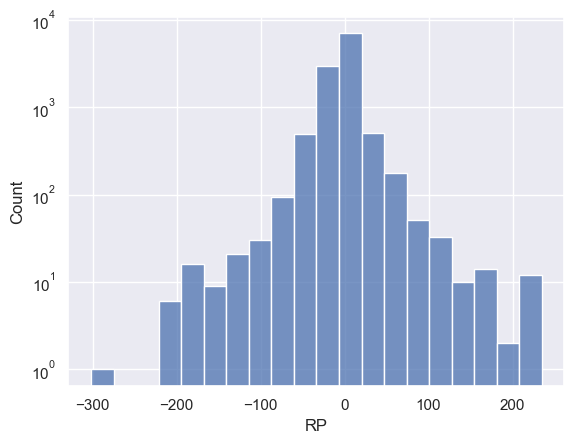

In [15]:
# what is the quality of the initial guess?

r = data["RP"] - np.round(RP(x0))
pd.Series(r).describe()

# _ = plt.figure()
# g = sns.histplot(x=np.clip(np.abs(r), 1e-1,1e3), log_scale=True, bins=20)
# g.axes.set_yscale('log')
# _ = g.bar_label(g.containers[1], labels= [str(v) if v else '' for v in g.containers[1].datavalues])

_ = plt.figure()
g = sns.histplot(x=r, bins=20)
_ = g.axes.set_yscale('log')
#_ = g.bar_label(g.containers[1], labels=[str(v) if v else '' for v in g.containers[1].datavalues])

In [16]:
cache_fit = True

# least_squares gives a deterministic result that depends on x0, the data, and the optimizer options
# hash the data as well as x0 to decide if we reuse last fit

store = (DataStore()
         .with_dependency_on(data, x0)
         .try_read_and_validate(FitOptions.result_file)
         )

if cache_fit and store.is_valid() :
    opt = store.data()
    print("Loaded from cache")

else:

    opt = progressive_soft_round_loop(x0,
        lambda x: scipy.optimize.least_squares(residual, x, **FitOptions.least_squares_kwargs)
    )

    # save results and remove some stuff we don't need to save.
    store.use_data(simplify_opt_result(opt)).save_to(FitOptions.result_file)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1506e+06                                    9.61e+08    
       1              9         9.9118e+05      1.59e+05       8.55e-04       1.02e+09    
       2             10         5.7374e+05      4.17e+05       2.14e-04       8.96e+08    
       3             11         3.8347e+05      1.90e+05       4.28e-04       8.94e+08    
       4             12         2.0800e+05      1.75e+05       1.07e-04       8.47e+08    
       5             13         2.0137e+05      6.63e+03       2.14e-04       8.47e+08    
       6             14         1.3304e+05      6.83e+04       5.35e-05       8.41e+08    
       7             15         9.4153e+04      3.89e+04       1.07e-04       8.37e+08    
       8             17         6.6179e+04      2.80e+04       2.67e-05       4.73e+08    
       9             18         5.4927e+04      1.13e+04       5.35e-05       5.33e+08    

In [17]:
opt

    message: `ftol` termination condition is satisfied.
    success: True
     status: 2
          x: [ 5.642e-01  5.480e-01 ...  3.694e-01  3.683e-01]
       cost: 2192.9521573295274
       grad: [-2.385e-04 -1.202e-04 ...  0.000e+00  0.000e+00]
 optimality: 0.1292664371430874
       nfev: 57
       njev: 40

count    11462.000000
mean         0.005235
std          0.634747
min        -13.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         18.000000
Name: RP, dtype: float64

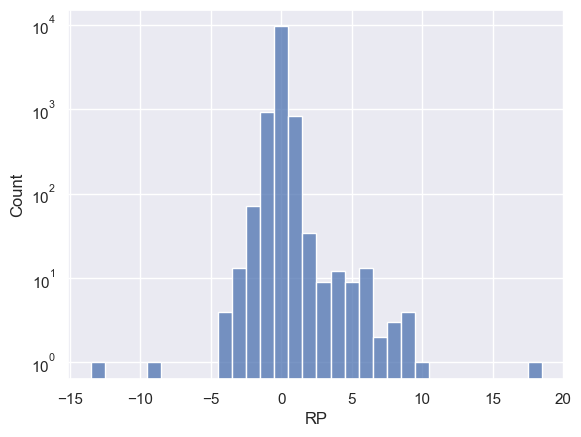

In [18]:
r_opt = data["RP"] - np.round(RP(opt.x))
pd.Series(r_opt).describe()

# _ = plt.figure()
# g = sns.histplot(x=np.clip(np.abs(r_opt), 1e-1,1e3), log_scale=True, bins=20)
# g.axes.set_yscale('log')
# _ = g.bar_label(g.containers[1], labels= [str(v) if v else '' for v in g.containers[1].datavalues])

_ = plt.figure()
g = sns.histplot(x=r_opt, discrete=1)
_ = g.axes.set_yscale('log')
#_ = g.bar_label(g.containers[1], labels=[str(v) if v else '' for v in g.containers[1].datavalues])


In [19]:
sol = unpack(opt.x, unpack_info)
table(sol)

Pokemons ing fractions,[0.25641653 0.25479829 0.26536809 ... 0.17714788 0.22472216 0.22890733]
Pokemons skill chances,[0.01899953 0.01900151 0.02105227 ... 0.0449927 0.01101406 0.01304665]
Ing Growth Poly,[ 0.00019006 0.00297224 -0.00119194]
Dream Shard Bonus,0.2209937355110958
Energy Recovery Bonus,0.22091435850276675
Helping Bonus,0.22111882717978798
Inventory Up S,0.07191776569197021
Inventory Up M,0.13935335037001048
Inventory Up L,0.18259687391442586
Research EXP Bonus,0.22117865036581974
Sleep EXP Bonus,0.22103579031374304


In [21]:
# Format ing% and skillProduct pretty

res = pd.DataFrame({
    "Pokemon": game.data.pokedex["Pokemon"], "ing%": sol["Pokemons ing fractions"] * 100.0,
    "skill%": sol["Pokemons skill chances"]
})
res.set_index("Pokemon")

,ing%,skill%
Pokemon,,
Bulbasaur,25.641653,0.019000
Ivysaur,25.479829,0.019002
Venusaur,26.536809,0.021052
Charmander,20.050883,0.011005
Charmeleon,22.700030,0.015982
...,...,...
Gallade,14.741498,0.053983
Sylveon,17.776079,0.039979
Dedenne,17.714788,0.044993


In [23]:
# What are the worst points?

df = data[["Pokemon", "ID", "Level", "MS lvl", "NatureP", "NatureN", "Sub Skill 1", "Sub Skill 2", "RP"]].copy()

df["fit"] = RP(opt.x)
df["error"] = data["RP"] - np.round(RP(opt.x))
df["error2"] = df["error"] ** 2

df = df.sort_values("error2", ascending=False).reset_index(drop=True)
df.head(100)


,Pokemon,ID,Level,MS lvl,NatureP,NatureN,Sub Skill 1,Sub Skill 2,RP,fit,error,error2
0,Glaceon,GlaceonNeutral276Skill Level Up MHelping Speed M,27.0,6.0,-,-,Skill Level Up M,Helping Speed M,2485.0,2467.223968,18.0,324.0
1,Venusaur,VenusaurMild323Helping BonusInventory Up L,32.0,3.0,Ingredient Finding,Energy Recovery,Helping Bonus,Inventory Up L,1863.0,1876.443979,-13.0,169.0
2,Typhlosion,TyphlosionCareful273Berry Finding SHelping Spe...,27.0,3.0,Main Skill Chance,Ingredient Finding,Berry Finding S,Helping Speed M,1761.0,1751.370230,10.0,100.0
3,Charizard,CharizardNeutral273Berry Finding SHelping Speed M,27.0,3.0,-,-,Berry Finding S,Helping Speed M,1528.0,1519.415483,9.0,81.0
4,Charizard,CharizardRash273Helping BonusHelping Speed M,27.0,3.0,Ingredient Finding,Main Skill Chance,Helping Bonus,Helping Speed M,1440.0,1431.407268,9.0,81.0
5,Slaking,SlakingGentle271Inventory Up LDream Shard Bonus,27.0,1.0,Main Skill Chance,Energy Recovery,Inventory Up L,Dream Shard Bonus,1188.0,1197.435362,-9.0,81.0
6,Togekiss,TogekissGentle103Skill Trigger M,10.0,3.0,Main Skill Chance,Energy Recovery,Skill Trigger M,,1282.0,1273.415519,9.0,81.0
7,Raichu,RaichuNaughty313Helping Speed SInventory Up S,31.0,3.0,Speed of Help,Main Skill Chance,Helping Speed S,Inventory Up S,1663.0,1654.117416,9.0,81.0
8,Charizard,CharizardMild276Skill Level Up MHelping Speed M,27.0,6.0,Ingredient Finding,Energy Recovery,Skill Level Up M,Helping Speed M,1514.0,1506.459729,8.0,64.0
9,Sylveon,SylveonRelaxed102Helping Bonus,10.0,2.0,Energy Recovery,EXP Gains,Helping Bonus,,1023.0,1015.240036,8.0,64.0
